In [1]:
import vega_sim
from vega_sim.null_service import VegaServiceNull

from vega_sim.scenario.common.utils.price_process import (
    Granularity,
    get_historic_price_series,
)
import vega_sim.proto.vega as vega_protos
from vega_sim.scenario.curve_market_maker.scenario import CurveMarketMaker
from vega_sim.scenario.common.agents import ShapedMarketMaker, MMOrder, LiquidityProvision

import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [2]:
vega = VegaServiceNull(warn_on_raw_data_access=False)
vega.start()

INFO:vega_sim.null_service:Running NullChain from vegahome of /var/folders/yj/cjhtlxn90wldd1hvw5lkxnrc0000gn/T/vega-sim-4793hy4e
INFO:vega_sim.null_service:Launching GraphQL node at port 63406
INFO:vega_sim.null_service:Launching Console at port 63412


In [3]:
scenario = CurveMarketMaker(
        market_name="ETH",
        asset_name="USD",
        num_steps=290,
        market_decimal=2,
        asset_decimal=4,
        market_position_decimal=4,
        initial_price=1000,
        lp_commitamount=250_000,
        initial_asset_mint=10_000_000,
        step_length_seconds=60,
        # step_length_seconds=Granularity.HOUR.value,
        block_length_seconds=1,
        q_upper=30,
        q_lower=-30,
        market_maker_curve_kappa=0.2,
        market_maker_assumed_market_kappa=0.2,
        buy_intensity=100,
        sell_intensity=100,
        sensitive_price_taker_half_life=10,
        opening_auction_trade_amount=0.0001,
        market_order_trader_base_order_size=0.01,
    )

In [6]:
scenario.agents = scenario.configure_agents(vega, tag="base", random_state=None)
scenario.env = scenario.configure_environment(vega)

In [7]:
scenario.env.run()

In [13]:
mm_pubkey = vega.wallet.public_key(scenario.agents['expon_shaped_market_maker_base'].wallet_name)

In [30]:
liq_fees = vega.list_ledger_entries(to_party_ids=[mm_pubkey], transfer_types=[vega_protos.vega.TransferType.TRANSFER_TYPE_LIQUIDITY_FEE_DISTRIBUTE])
liq_fee_df = pd.DataFrame.from_records([{'timestamp': datetime.datetime.fromtimestamp(le.timestamp / 1e9), 'quantity': le.quantity} for le in liq_fees], index='timestamp').sort_index()

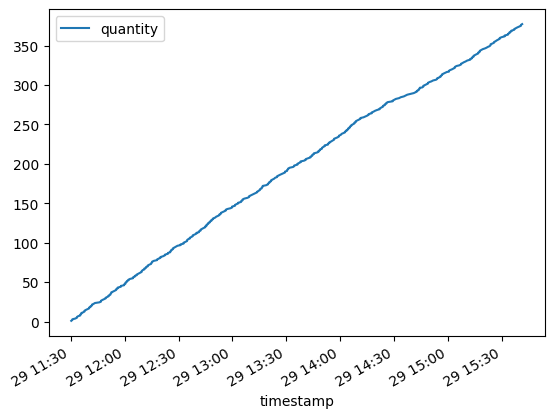

In [34]:
liq_fee_df.cumsum().plot()
plt.show()

### Narrow Fixed 

In [61]:
scenario.agents = scenario.configure_agents(vega, tag="single_wide", random_state=None)

wide_mm = ShapedMarketMaker(
    wallet_name="expon_wide",
    wallet_pass="expon",
    price_process_generator=iter(scenario.price_process),
    market_name=scenario.market_name + "_single_wide",
    asset_name=scenario.asset_name + "_single_wide",
    commitment_amount=scenario.lp_commitamount,
    market_decimal_places=scenario.market_decimal,
    asset_decimal_places=scenario.asset_decimal,
    tag='wide_mm',
    best_price_offset_fn=lambda a, b: (100, 100),
    shape_fn=lambda a, b: ([], []),
    liquidity_commitment_fn=lambda _: LiquidityProvision(
            amount=scenario.lp_commitamount,
            fee=0.00001,
            buy_specs=[
                [
                    "PEGGED_REFERENCE_MID",
                    5,
                    1,
                ]
            ],
            sell_specs=[
                [
                    "PEGGED_REFERENCE_MID",
                    5,
                    1,
                ]
            ],
    )
)

scenario.agents['mm_wide'] = wide_mm

scenario.env = scenario.configure_environment(vega)
scenario.env.run()

In [62]:
mm_pubkey = vega.wallet.public_key(scenario.agents['expon_shaped_market_maker_single_wide'].wallet_name)
mm_wide_pubkey = vega.wallet.public_key(scenario.agents['mm_wide'].wallet_name)

liq_fees = vega.list_ledger_entries(to_party_ids=[mm_pubkey], transfer_types=[vega_protos.vega.TransferType.TRANSFER_TYPE_LIQUIDITY_FEE_DISTRIBUTE])
liq_fees_wide = vega.list_ledger_entries(to_party_ids=[mm_wide_pubkey], transfer_types=[vega_protos.vega.TransferType.TRANSFER_TYPE_LIQUIDITY_FEE_DISTRIBUTE])

liq_fee_df = pd.DataFrame.from_records([{'timestamp': datetime.datetime.fromtimestamp(le.timestamp / 1e9), 'quantity': le.quantity, 'party': le.receiver_party_id} for le in liq_fees], index='timestamp').sort_index()
liq_fee_wide_df = pd.DataFrame.from_records([{'timestamp': datetime.datetime.fromtimestamp(le.timestamp / 1e9), 'quantity': le.quantity, 'party': le.receiver_party_id} for le in liq_fees_wide], index='timestamp').sort_index()

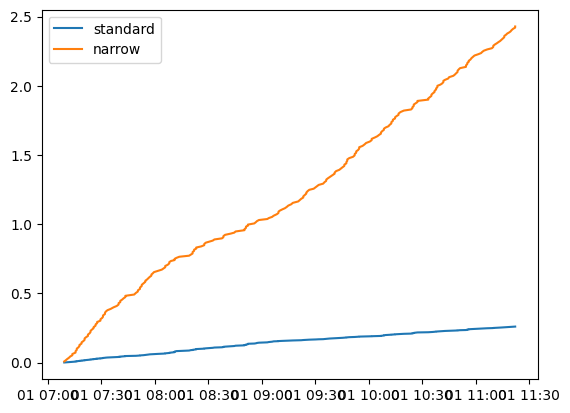

In [63]:
plt.plot(liq_fee_df.quantity.cumsum().index, liq_fee_df.quantity.cumsum().values, label='standard')
plt.plot(liq_fee_wide_df.quantity.cumsum().index, liq_fee_wide_df.quantity.cumsum().values, label='narrow')
plt.legend()

plt.show()

### Approx Equal Fixed 

In [51]:
scenario.agents = scenario.configure_agents(vega, tag="single_wide", random_state=None)

wide_mm = ShapedMarketMaker(
    wallet_name="expon_wide",
    wallet_pass="expon",
    price_process_generator=iter(scenario.price_process),
    market_name=scenario.market_name + "_single_wide",
    asset_name=scenario.asset_name + "_single_wide",
    commitment_amount=scenario.lp_commitamount,
    market_decimal_places=scenario.market_decimal,
    asset_decimal_places=scenario.asset_decimal,
    tag='wide_mm',
    best_price_offset_fn=lambda a, b: (100, 100),
    shape_fn=lambda a, b: ([], []),
    liquidity_commitment_fn=lambda _: LiquidityProvision(
            amount=scenario.lp_commitamount,
            fee=0.00001,
            buy_specs=[
                [
                    "PEGGED_REFERENCE_MID",
                    25,
                    1,
                ]
            ],
            sell_specs=[
                [
                    "PEGGED_REFERENCE_MID",
                    25,
                    1,
                ]
            ],
    )
)

scenario.agents['mm_wide'] = wide_mm

scenario.env = scenario.configure_environment(vega)
scenario.env.run()

In [52]:
mm_pubkey = vega.wallet.public_key(scenario.agents['expon_shaped_market_maker_single_wide'].wallet_name)
mm_wide_pubkey = vega.wallet.public_key(scenario.agents['mm_wide'].wallet_name)

liq_fees = vega.list_ledger_entries(to_party_ids=[mm_pubkey], transfer_types=[vega_protos.vega.TransferType.TRANSFER_TYPE_LIQUIDITY_FEE_DISTRIBUTE])
liq_fees_wide = vega.list_ledger_entries(to_party_ids=[mm_wide_pubkey], transfer_types=[vega_protos.vega.TransferType.TRANSFER_TYPE_LIQUIDITY_FEE_DISTRIBUTE])

liq_fee_df = pd.DataFrame.from_records([{'timestamp': datetime.datetime.fromtimestamp(le.timestamp / 1e9), 'quantity': le.quantity, 'party': le.receiver_party_id} for le in liq_fees], index='timestamp').sort_index()
liq_fee_wide_df = pd.DataFrame.from_records([{'timestamp': datetime.datetime.fromtimestamp(le.timestamp / 1e9), 'quantity': le.quantity, 'party': le.receiver_party_id} for le in liq_fees_wide], index='timestamp').sort_index()

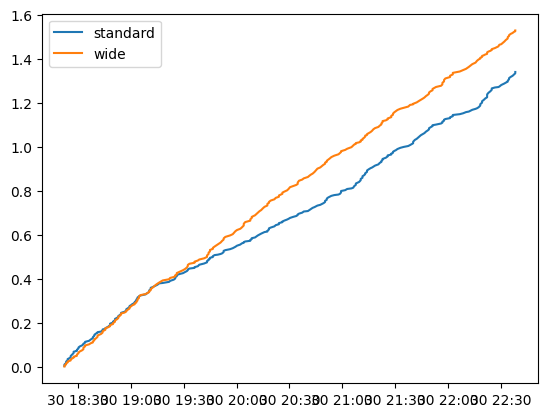

In [53]:
plt.plot(liq_fee_df.quantity.cumsum().index, liq_fee_df.quantity.cumsum().values, label='standard')
plt.plot(liq_fee_wide_df.quantity.cumsum().index, liq_fee_wide_df.quantity.cumsum().values, label='wide')
plt.legend()

plt.show()

### Wide Fixed 

In [64]:
scenario.agents = scenario.configure_agents(vega, tag="single_wide", random_state=None)

wide_mm = ShapedMarketMaker(
    wallet_name="expon_wide",
    wallet_pass="expon",
    price_process_generator=iter(scenario.price_process),
    market_name=scenario.market_name + "_single_wide",
    asset_name=scenario.asset_name + "_single_wide",
    commitment_amount=scenario.lp_commitamount,
    market_decimal_places=scenario.market_decimal,
    asset_decimal_places=scenario.asset_decimal,
    tag='wide_mm',
    best_price_offset_fn=lambda a, b: (100, 100),
    shape_fn=lambda a, b: ([], []),
    liquidity_commitment_fn=lambda _: LiquidityProvision(
            amount=scenario.lp_commitamount,
            fee=0.00001,
            buy_specs=[
                [
                    "PEGGED_REFERENCE_MID",
                    50,
                    1,
                ]
            ],
            sell_specs=[
                [
                    "PEGGED_REFERENCE_MID",
                    50,
                    1,
                ]
            ],
    )
)

scenario.agents['mm_wide'] = wide_mm

scenario.env = scenario.configure_environment(vega)
scenario.env.run()

In [65]:
mm_pubkey = vega.wallet.public_key(scenario.agents['expon_shaped_market_maker_single_wide'].wallet_name)
mm_wide_pubkey = vega.wallet.public_key(scenario.agents['mm_wide'].wallet_name)

liq_fees = vega.list_ledger_entries(to_party_ids=[mm_pubkey], transfer_types=[vega_protos.vega.TransferType.TRANSFER_TYPE_LIQUIDITY_FEE_DISTRIBUTE])
liq_fees_wide = vega.list_ledger_entries(to_party_ids=[mm_wide_pubkey], transfer_types=[vega_protos.vega.TransferType.TRANSFER_TYPE_LIQUIDITY_FEE_DISTRIBUTE])

liq_fee_df = pd.DataFrame.from_records([{'timestamp': datetime.datetime.fromtimestamp(le.timestamp / 1e9), 'quantity': le.quantity, 'party': le.receiver_party_id} for le in liq_fees], index='timestamp').sort_index()
liq_fee_wide_df = pd.DataFrame.from_records([{'timestamp': datetime.datetime.fromtimestamp(le.timestamp / 1e9), 'quantity': le.quantity, 'party': le.receiver_party_id} for le in liq_fees_wide], index='timestamp').sort_index()

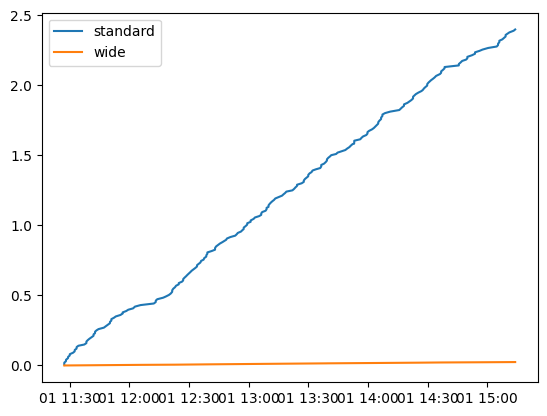

In [66]:
plt.plot(liq_fee_df.quantity.cumsum().index, liq_fee_df.quantity.cumsum().values, label='standard')
plt.plot(liq_fee_wide_df.quantity.cumsum().index, liq_fee_wide_df.quantity.cumsum().values, label='wide')
plt.legend()

plt.show()